In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from BinanceCollector import BinanceCollector
from TradeBook import TradeBook
import warnings
warnings.filterwarnings("ignore")
from BreakdownCalculator import BreakdownCalculator

c:\Users\deves\AppData\Local\Programs\Python\Python37\lib\site-packages\requests\__init__.py:114: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning,


In [43]:
collector = BinanceCollector("UNIUSDT","2022-01-01","2022-12-31","15m")
collector.start_collect()
collector.df.columns = ["Open Time","Open","High","Low","Close","Volume","Close Time",
             "Quote asset volumne","Total Trades","Buyer Base Volume",
             "Taker buy quote asset volume","Ignore"]
df = collector.df
breakdown = BinanceCollector("UNIUSDT","2022-01-01","2022-12-31","1m")
breakdown.start_collect()
breakdown.df.columns = ["Open Time","Open","High","Low","Close","Volume","Close Time",
             "Quote asset volumne","Total Trades","Buyer Base Volume",
             "Taker buy quote asset volume","Ignore"]
breakdown_df = breakdown.df
calculator = BreakdownCalculator(breakdown_df)

In [44]:
df["Open Time"] = pd.to_datetime(df["Open Time"],unit="ms")
df["Close Time"] = pd.to_datetime(df["Close Time"]+1,unit="ms")
open_time = df["Open Time"]

In [45]:
df["EMA_20"] = df["Close"].ewm(span=20,adjust=False).mean()
df["EMA_50"] = df["Close"].ewm(span=50,adjust=False).mean()
df["EMA_200"] = df["Close"].ewm(span=200,adjust=False).mean()

df = df[["Open","High","Low","Close","EMA_20","EMA_50","EMA_200"]]

# Normalising Data
# df = (df - df.mean())/df.std()

In [46]:
df["Buy"] = np.where( (df["EMA_20"] > df["EMA_50"]) & (df["EMA_20"].shift(1) <= df["EMA_50"].shift(1) ),1,0 )
df["Sell"] = np.where( (df["EMA_20"] < df["EMA_50"]) & (df["EMA_20"].shift(1) >= df["EMA_50"].shift(1) ),1,0 )
df["Returns"] = 0
df["Open Time"] = open_time

In [47]:
df.tail()

,Open,High,Low,Close,EMA_20,EMA_50,EMA_200,Buy,Sell,Returns,Open Time
34575,5.087,5.087,5.075,5.083,5.080373,5.069215,5.066161,0,0,0,2022-12-30 22:45:00
34576,5.083,5.099,5.083,5.097,5.081956,5.070304,5.066468,0,0,0,2022-12-30 23:00:00
34577,5.098,5.098,5.094,5.097,5.083389,5.071351,5.066772,0,0,0,2022-12-30 23:15:00
34578,5.098,5.100,5.095,5.100,5.084971,5.072475,5.067102,0,0,0,2022-12-30 23:30:00
34579,5.100,5.102,5.090,5.098,5.086212,5.073476,5.067410,0,0,0,2022-12-30 23:45:00


In [53]:
max_time = 1*(24*60/15) # Days*C

target = 5/100
sl = -2/100
wins = 0
losses = 0
# For each buy signal
for i in np.where( (df["Buy"] == 1) )[0]:
    target_price = df["Close"][i] * (1+target)
    sl_price = df["Close"][i] * (1+sl)
    from_time = df["Open Time"][i]
    to_time = min(df["Open Time"][i] + pd.Timedelta(minutes=15*max_time),df["Open Time"][len(df) - 1])
    df["Returns"][i] = calculator.calculate(from_time,to_time,target_price,sl_price) - 0.1
    if df["Returns"][i] > 0:
        wins += 1
    else:
        losses += 1

target = -4/100
sl = 2/100
wins = 0
losses = 0
# For each sell signal
for i in np.where( (df["Sell"] == 1) )[0]:
    target_price = df["Close"][i] * (1+target)
    sl_price = df["Close"][i] * (1+sl)
    from_time = df["Open Time"][i]
    to_time = min(df["Open Time"][i] + pd.Timedelta(minutes=15*max_time),df["Open Time"][len(df) - 1])
    df["Returns"][i] = calculator.calculate(from_time,to_time,target_price,sl_price,trade="short") - 0.1
    if df["Returns"][i] > 0:
        wins += 1
    else:
        losses += 1

<AxesSubplot:>

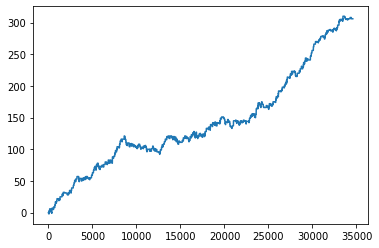

In [54]:
df["Returns"].cumsum().plot()

In [52]:
df[ df["Returns"] != 0 ]

,Open,High,Low,Close,EMA_20,EMA_50,EMA_200,Buy,Sell,Returns,Open Time
1,17.040,17.220,17.020,17.180,17.053333,17.045490,17.041393,1,0,-1,2022-01-01 00:30:00
42,17.090,17.130,17.000,17.020,17.159672,17.166476,17.099357,0,1,-1,2022-01-01 10:45:00
68,17.140,17.160,17.130,17.160,17.135277,17.133858,17.101011,1,0,5,2022-01-01 17:15:00
118,17.210,17.220,17.160,17.180,17.280032,17.286200,17.186525,0,1,-1,2022-01-02 06:00:00
134,17.380,17.410,17.350,17.380,17.272400,17.270030,17.194928,1,0,4,2022-01-02 10:00:00
...,...,...,...,...,...,...,...,...,...,...,...
33992,5.235,5.241,5.235,5.238,5.225675,5.225023,5.253365,1,0,-1,2022-12-24 19:30:00
33998,5.216,5.218,5.210,5.213,5.223795,5.224463,5.251588,0,1,2,2022-12-24 21:00:00
34264,5.185,5.200,5.171,5.199,5.225746,5.227351,5.202180,0,1,2,2022-12-27 16:15:00
34410,5.088,5.101,5.088,5.094,5.038240,5.034964,5.095842,1,0,-2,2022-12-29 05:15:00


In [8]:
# tmp = calculator.df_main

In [74]:
from datetime import datetime
str(datetime.utcnow().timestamp()*1000).split(".")[0]

'1672652259680'

In [101]:
# tmp = df[20:45]

In [100]:
# tmp["Test"] = 3705 - df["High"]
# tmp["Test2"] = df["Low"] - 3695

In [99]:
# tmp